In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [46]:
# DataSet generation using TimeSeriesSplit
data_set = dict()

with open("stocks.txt", "r") as f:
    stocks = [line.strip() for line in f if line.strip()]

def make_tscv_splits(X, y, initial_train_ratio=0.6, test_ratio=0.2, min_test_size=1):
    """
    Build walk-forward splits using sklearn TimeSeriesSplit.
    Returns list of dicts with X_train, X_test, Y_train, Y_test.
    """
    X = X.sort_index()
    y = y.loc[X.index]

    n = len(X)
    if n == 0:
        return []

    initial_train_size = max(1, int(np.floor(n * initial_train_ratio)))
    test_size = max(min_test_size, int(np.floor(n * test_ratio)))
    # compute a reasonable n_splits for TimeSeriesSplit
    possible_splits = max(1, (n - initial_train_size) // test_size)
    if possible_splits < 1:
        # fallback to single chronological split
        mid = max(1, int(np.floor(n * 0.8)))
        return [{
            "X_train": X.iloc[:mid],
            "X_test": X.iloc[mid:],
            "Y_train": y.iloc[:mid],
            "Y_test": y.iloc[mid:]
        }]

    tscv = TimeSeriesSplit(n_splits=possible_splits)
    splits = []
    for train_idx, test_idx in tscv.split(X):
        # ensure initial training size constraint
        if train_idx.size < initial_train_size:
            continue
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        Y_train = y.iloc[train_idx]
        Y_test = y.iloc[test_idx]
        if len(X_train) == 0 or len(X_test) == 0:
            continue
        splits.append({
            "X_train": X_train,
            "X_test": X_test,
            "Y_train": Y_train,
            "Y_test": Y_test
        })

    # if nothing created, fallback to single chronological split
    if not splits:
        mid = max(1, int(np.floor(n * 0.8)))
        splits.append({
            "X_train": X.iloc[:mid],
            "X_test": X.iloc[mid:],
            "Y_train": y.iloc[:mid],
            "Y_test": y.iloc[mid:]
        })

    return splits

for stock in stocks:
    df = pd.read_csv(
        f"csv/{stock}_indicators.csv",
        index_col=0,
        parse_dates=[0],
        date_format="ISO8601"
    )

    df = df.apply(pd.to_numeric, errors='coerce')

    # create target (example: next-day return) and drop NaNs produced by shift
    if "Target" not in df.columns and "Return" in df.columns:
        df["Target"] = df["Return"].shift(-1)

    df = df.dropna(subset=["Target"])
    df = df.dropna()  # remove rows with NaNs in features

    if df.empty:
        print(f"Skipping {stock}: no valid rows after cleaning")
        continue

    X = df.drop(columns=["Target"])
    Y = df["Target"]

    splits = make_tscv_splits(X, Y, initial_train_ratio=0.4, test_ratio=0.2)

    if not splits:
        print(f"Skipping {stock}: no splits created")
        continue

    data_set[stock] = {
        "X": X,
        "Y": Y,
        "splits": splits
    }

    print("="*10 + f" {stock} " + "="*10)
    print(f"Total rows: {len(X)} | Splits: {len(splits)}")
    for i, s in enumerate(splits):
        print(f"  split {i+1}: train={len(s['X_train'])}, test={len(s['X_test'])}")
    print()

========== AAPL ==========
Total rows: 2481 | Splits: 2
  split 1: train=1241, test=620
  split 2: train=1861, test=620

========== META ==========
Total rows: 2481 | Splits: 2
  split 1: train=1241, test=620
  split 2: train=1861, test=620

========== ORCL ==========
Total rows: 2481 | Splits: 2
  split 1: train=1241, test=620
  split 2: train=1861, test=620

========== MSFT ==========
Total rows: 2481 | Splits: 2
  split 1: train=1241, test=620
  split 2: train=1861, test=620




=== XGBoost training for AAPL ===
  split 1: best_params={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7} | RMSE=0.0178 MAE=0.0125 R2=0.0222


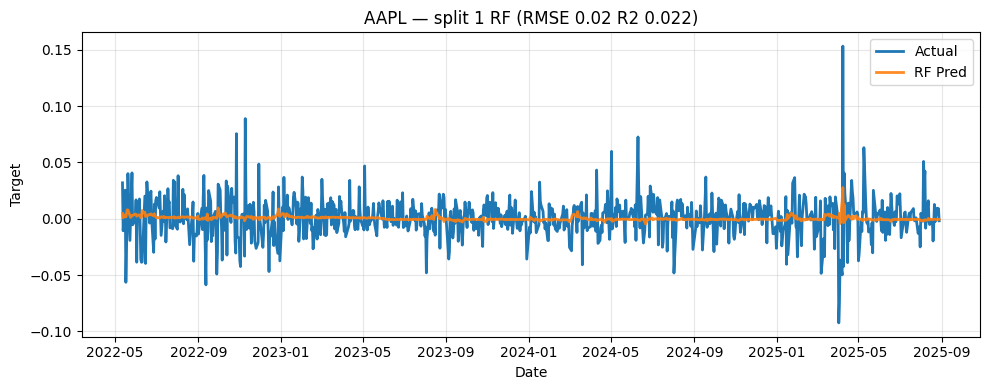

  Top features (avg importance):
Dist_up_band     0.081778
Dist_low_band    0.074606
%K               0.064170
High             0.060925
SMA              0.057455
Return           0.056867
Return-1         0.053857
RSI              0.051730
%D               0.049354
MACD             0.047274

=== XGBoost training for META ===
  split 1: best_params={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7} | RMSE=0.0278 MAE=0.0181 R2=-0.0027


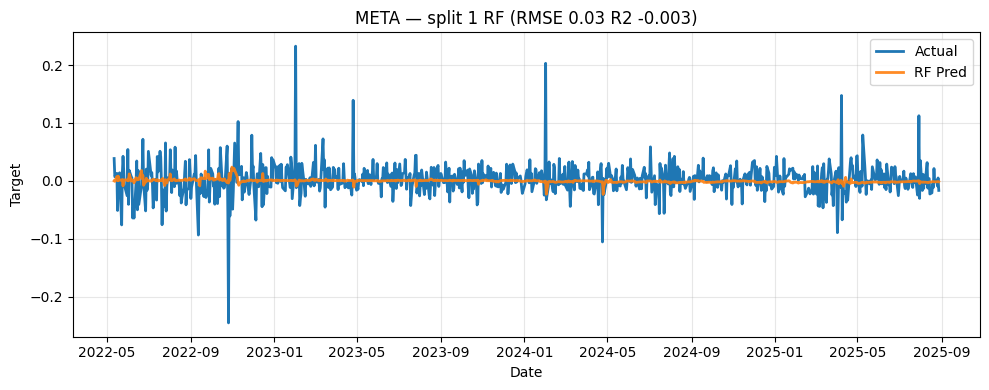

  Top features (avg importance):
EMA200         0.065462
EMA50          0.060213
Low            0.059738
Volume         0.055338
Vol_EMA200     0.053038
Return-1       0.052199
SMA            0.049761
Open           0.044498
Return-7       0.043328
Close_STD20    0.042315

=== XGBoost training for ORCL ===
  split 1: best_params={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0} | RMSE=0.0228 MAE=0.0152 R2=-0.0382


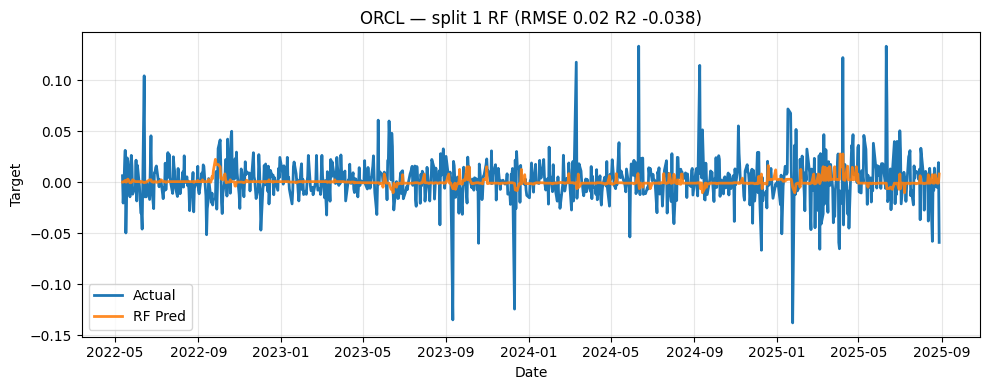

  Top features (avg importance):
Boll_Down        0.125230
Volume           0.125111
Close            0.110137
Dist_up_band     0.099160
Dist_low_band    0.082654
MACD             0.082538
RSI              0.077778
%K               0.058808
Return           0.053993
Return-1         0.036295

=== XGBoost training for MSFT ===
  split 1: best_params={'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7} | RMSE=0.0166 MAE=0.0120 R2=-0.0011


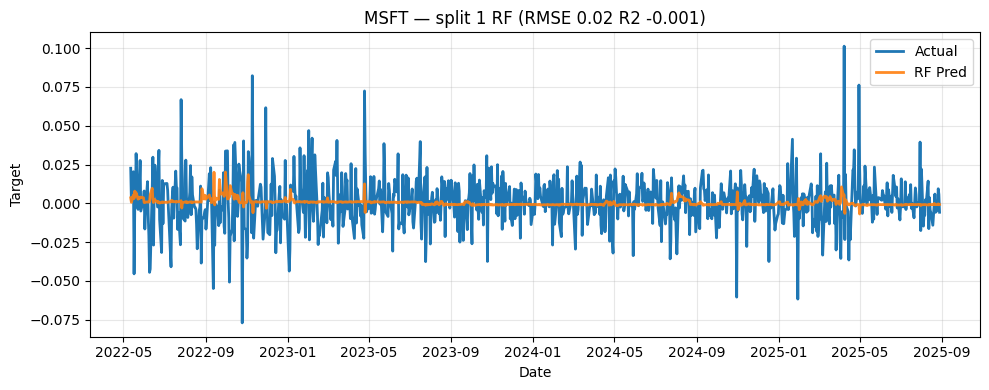

  Top features (avg importance):
%K               0.100221
Return           0.086859
Dist_up_band     0.083327
Return-1         0.059050
RSI              0.052606
MACD_Signal      0.047755
Return-7         0.046162
MACD             0.044821
Dist_low_band    0.043571
EMA200           0.041453

=== All splits summary ===
stock  split     rmse      mae        r2                                                                    best_params
 MSFT      1 0.016599 0.011951 -0.001116 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
 AAPL      1 0.017795 0.012489  0.022177 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
 ORCL      1 0.022839 0.015220 -0.038247 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
 META      1 0.027834 0.018076 -0.002693 {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}

=== Per-stock summary ===
     n_splits mean_rmse  mean_mae   mean_r2
AAPL    

In [ ]:
results = []
per_stock_summary = {}

if 'data_set' not in locals() or not data_set:
    raise RuntimeError("data_set is missing or empty - run the dataset generation cell first")

for stock, ds in data_set.items():
    print(f"\n=== XGBoost training for {stock} ===")
    splits = ds.get("splits", [])
    if not splits:
        print("  no splits found, skipping")
        continue

    stock_results = []
    agg_feature_importances = None

    for i, split in enumerate(splits, start=1):
        X_train = split["X_train"]
        X_test = split["X_test"]
        y_train = split["Y_train"]
        y_test = split["Y_test"]

        if len(X_train) == 0 or len(X_test) == 0:
            print(f"  split {i}: empty, skipping")
            continue

        # grid (small) - adjust to taste
        xgb = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', verbosity=0)
        param_grid = {
            "n_estimators": [100, 300, 500, 1000],
            "max_depth": [3, 6, 10],
            "learning_rate": [0.01, 0.05, 0.1],
            "subsample": [0.5,0.7, 1.0]
        }
        gs = GridSearchCV(xgb, param_grid, scoring="neg_mean_squared_error", cv=3, n_jobs=-1, verbose=0)
        gs.fit(X_train, y_train)

        best = gs.best_estimator_
        y_pred = best.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"  split {i}: best_params={gs.best_params_} | RMSE={rmse:.4f} MAE={mae:.4f} R2={r2:.4f}")

        stock_results.append({
            "stock": stock,
            "split": i,
            "rmse": rmse,
            "mae": mae,
            "r2": r2,
            "best_params": gs.best_params_
        })

        # accumulate feature importances
        try:
            fi = pd.Series(best.feature_importances_, index=X_train.columns)
            if agg_feature_importances is None:
                agg_feature_importances = fi.copy()
            else:
                agg_feature_importances += fi
        except Exception:
            pass

        # quick plot for this split
        plt.figure(figsize=(10,4))
        plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
        plt.plot(y_test.index, y_pred, label="RF Pred", linewidth=2, alpha=0.9)
        plt.title(f"{stock} — split {i} RF (RMSE {rmse:.2f} R2 {r2:.3f})")
        plt.xlabel("Date")
        plt.ylabel("Target")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    # finalize per-stock summary
    if stock_results:
        per_stock_summary[stock] = {
            "n_splits": len(stock_results),
            "mean_rmse": float(np.mean([r["rmse"] for r in stock_results])),
            "mean_mae": float(np.mean([r["mae"] for r in stock_results])),
            "mean_r2": float(np.mean([r["r2"] for r in stock_results])),
            "splits": stock_results
        }

        # average feature importances across splits (if collected)
        if agg_feature_importances is not None:
            agg_feature_importances = agg_feature_importances / len(stock_results)
            print("  Top features (avg importance):")
            print(agg_feature_importances.sort_values(ascending=False).head(10).to_string())

    results.extend(stock_results)

# Display overall summary table
if results:
    summary_df = pd.DataFrame(results).sort_values("rmse")
    print("\n=== All splits summary ===")
    print(summary_df.to_string(index=False))
    print("\n=== Per-stock summary ===")
    print(pd.DataFrame(per_stock_summary).T[["n_splits", "mean_rmse", "mean_mae", "mean_r2"]].to_string())